# Подключение GPU ускорителя и библиотек для LightGBM

In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 24503, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 24503 (delta 5), reused 0 (delta 0), pack-reused 24480
Receiving objects: 100% (24503/24503), 19.20 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (18068/18068), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Compressing 

In [ ]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
import random
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
import lightgbm as lgbm

# Функции для работы с LightGBM

subm() - функция сохраняет .csv файл для проверки на KAGGLE

In [34]:
'''
name - название будущего .csv файла с предсказаниями
y_pred - numpy список / столбец pd.Series с результатами на тест данных без таргета
'''
 
def subm(name, y_pred):
  write_submission = pd.read_csv('/content/drive/MyDrive/Лекции/ML/ДЗ-3/data/sample_submission.csv')
  write_submission['TARGET'] = y_pred
  write_submission.to_csv(name + '.csv', index= False)

my_cross_valid() - Собственная реализация кросс-валидации.

Особенности:
* Сохранение пропорций объектов с таргетом 0 и 1 на тренировочном и валидационном сетах
* Неизменяемые наборы фолдов для теста всех параметров
* Проверяет влияние каждого гиперпараметра на итоговый AUC score

Мотивация:
* Количество 0 в таргете значительно превышает 1
* Для справедливой проверки и получения сравниваемых результатах необходимо проверять score метрики на одинаковых наборах данных

Пример:
* Датасет, где у 100 объектов таргет 0 и у 20 объектов 1 при разбивке на 5 каждый фолд будет содержать 20 объектов с таргетом 0 и 4 объекта с таргетом 1.

In [4]:
'''
train_matrix - Матрица train + target
k - количество фолдов
params - параметры модели LightGBM
test_matrix - Матрица test для предикта на kaggle
check_params - Словарь гиперпараметров на проверку
num_boost_round (по дефолту 200) - Количество эпох

Возвращает 2 словаря с результатами score по проверяемым параметрам.
1 словарь - набор score на валидационной выборке
2 словарь - набор score на train выборке
Словари хронят результаты след образом:
{'название_параметра': ['значение_параметра:auc_score']}
'''

def my_cross_valid(train_matrix, k, params, test_matrix, check_params, num_boost_round = 200):
  print(f'Оригинальные параметры обучения: {params}\n')
  temp_params = params.copy()
  res_dict = {}
  res_test_dict = {}
  best_score = 0
  # Узнаю и сохраняю индексы матрицы у 1 и 0
  ind_0 = train_matrix[train_matrix['TARGET'] == 0].sample(frac=1).index
  ind_1 = train_matrix[train_matrix['TARGET'] == 1].sample(frac=1).index
  # Создаю список списков с индексами объектов для фолдов (индексы 0 и 1 перемешаны)
  n_samp_el_0 = int(len(ind_0) / k)
  n_samp_el_1 = int(len(ind_1) / k)
  # Прибавляю к срезу с ответами из 0 срез с 1 и перемешиваю список индексов внутри списка
  ind_of_folds = [list(ind_0[:n_samp_el_0])]
  ind_of_folds[0].extend(list(ind_1[:n_samp_el_1]))
  random.shuffle(ind_of_folds[0])
  # Дополняю список списками индексов остальных фолдов
  for i in range(1, k):
    ind_of_folds.append(list(ind_0[n_samp_el_0 * (i) : n_samp_el_0 * (i + 1)]))
    ind_of_folds[i].extend(list(ind_1[n_samp_el_1 * (i) : n_samp_el_1 * (i + 1)]))
    random.shuffle(ind_of_folds[i])
  # Зануляю значения, в которых лежали индексы
  ind_0, ind_1 = 0, 0
  auc_list = []
  auc_test_list = []
  for key in check_params.keys():
    res_dict[key] = []
    res_test_dict[key] = []
    for par in check_params[key]:
      temp_params[key] = par
      # Работаю с фолдом по индексам
      print('Параметры обучения: ',temp_params)
      print(f'Проверяем параметр {key} = {par} \n')
      for i in range(k):
        # Отделяю таргет у выборок train & valid
        train_sample = train_matrix.drop(labels = ind_of_folds[i], axis = 0).copy()
        valid_sample = train_matrix.iloc[ind_of_folds[i]].copy()
        train_target = train_sample['TARGET'].copy()
        valid_target = valid_sample['TARGET'].copy()
        train_sample = train_sample.drop(labels = 'TARGET', axis = 1)
        valid_sample = valid_sample.drop(labels = 'TARGET', axis = 1)
        # Помещаю данные в переменную, читаемую алгоритмом LightGBM
        train_data = lgbm.Dataset(train_sample, label=train_target)
        valid_data = lgbm.Dataset(valid_sample, label=valid_target)
        # Тренирую модель на num_boost_round эпохах
        lgbm_model =lgbm.train(temp_params,
                              train_data,
                              valid_sets = (valid_data,), 
                              #  positional argument follows keyword argument,
                              num_boost_round = num_boost_round,
                              verbose_eval = 100)
        y_pred=lgbm_model.predict(valid_sample)
        # Считаю score модели
        auc_list.append(roc_auc_score(valid_target,y_pred))
        auc_test_list.append(roc_auc_score(train_target,lgbm_model.predict(train_sample)))
        if max(auc_list) > best_score:
          best_score = max(auc_list)
          subm('best_score_'+str(num_boost_round), lgbm_model.predict(test_matrix))
        print(f'На {i+1} фолде ROC AUC = {auc_list[i]}')
      temp_score = round(sum(auc_list) / len(auc_list), 6)
      temp_test_score = round(sum(auc_test_list) / len(auc_test_list), 6)
      print(f'Проверка параметра {key} = {par} завершилась со средним значением AUC = {temp_score}\n')
      res_dict[key].append(str(par) + ':' + str(temp_score))
      res_test_dict[key].append(str(par) + ':' + str(temp_test_score))
      auc_list = []
      auc_test_list = []
      temp_params = params.copy()
      print('*' * 80)
  print(f'Лучший SCORE на 1 ФОЛДЕ = {best_score}')
  return res_dict, res_test_dict


Функция для извлечения записанных скоров на кастомной кросс-валидации из списка со значениями "value:score"


In [5]:
'''
На вход подается список вида ['значение_параметра_1:auc_score_1', 'значение_параметра_2:auc_score_2', ...]
На выходе у функции 2 списка:
1) список значений параметров
2) список auc_score'ов
'''

def extract_scores(list_scores):
  list_params = []
  list_dbl_scores = []
  for i in list_scores:
    temp_index = [i.index(sign) for sign in i if sign == ':'][0]
    param, dbl_score = float(i[:temp_index]), float(i[temp_index + 1:])
    list_params.append(param)
    list_dbl_scores.append(dbl_score)
  return list_params, list_dbl_scores

# Обработка данных

* df_test - DF для тестов (без таргета)
* df_train - DF для обучения (без таргета)
* df_target - DF с целевой переменной

In [6]:
# Оригинальная TEST выборка БЕЗ target
df_test = pd.read_csv("/content/drive/MyDrive/Лекции/ML/ДЗ-3/data/application_test.csv")
# Оригинальная TRAIN выборка C target
df_train = pd.read_csv("/content/drive/MyDrive/Лекции/ML/ДЗ-3/data/application_train.csv")
# TARGET к объектам train
df_target = df_train.TARGET.copy()
# Удаляю target из train выборки
df_train = df_train.drop("TARGET", axis = 1)

Фичи типа Object. Нужно поменять тип на "category"

In [7]:
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
  'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 
  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
  'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
  'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
  'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

Преобразование категориальных фичей в читаемый LightGBM формат

In [8]:
train_matrix = df_train.copy()
test_matrix = df_test.copy()

for col in train_matrix.columns:
  if train_matrix[col].dtype == 'object':
    train_matrix[col] = train_matrix[col].astype('category')
    test_matrix[col] = test_matrix[col].astype('category')

Тестовый набор

In [ ]:
a = pd.DataFrame([[1,2,3,4,1],
                  [5,6,7,8,1],
                  [9,10,11,12,1],
                  [1,2,3,4,0],
                  [1,2,3,4,1],
                  [1,2,3,4,0],
                  [1,2,3,4,1],
                  [1,2,3,4,0],
                  [1,2,3,4,1]
                  ], 
                 columns = ['A','B','C','D', 'TARGET'])
print(a.shape)
a.head(10)

# Полигон
# --------------------------------------

# LightGBM на полном наборе данных без Категориальных фичей

удаляю из обучающей матрицы признаков категориальные признаки и перевожу данные в читаемый LightGBM формат.

In [ ]:
train_no_cat_matrix = train_matrix.drop(labels = cat_features, axis = 1)
test_no_cat_matrix = test_matrix.drop(labels = cat_features, axis = 1)
train_data = lgbm.Dataset(train_no_cat_matrix, label=df_target)

Параметры модели, обучение и предикт

In [ ]:
params = {
    'boosting_type':'gbdt',
    'learning_rate': 0.1,
    'objective': 'binary',
    'metric':'auc',
    'max_depth': 4,
}
lgbm_model = lgbm.train(params,train_data,200)
y_pred=lgbm_model.predict(test_no_cat_matrix)

Сохраняю результат предикта в .csv файл для Сабмита на Kaggle

In [ ]:
name = 'no_cats_200'
subm(name, y_pred)

Предикт на обученных данных (знаю, что так нельзя, но с валидационными сетами результаты ниже):

In [ ]:
y_pred = lgbm_model.predict(train_no_cat_matrix)
print(f'AUC Score на train данных: {round(roc_auc_score(df_target, y_pred),5)}')

AUC Score на train данных: 0.77952


Результаты на Kaggle:
* Private Score 0.73717
* Public Score 0.73671

Неплохо для начала

# LightGBM на полном наборе данных с Категориальными фичами

перевожу данные в читаемый LightGBM формат

In [ ]:
train_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float64(65), int64(40)
memory usage: 251.0 MB


In [ ]:
train_data = lgbm.Dataset(train_matrix, label=df_target)

Параметры модели, обучение и предикт

In [ ]:
params = {
    'boosting_type':'gbdt',
    'learning_rate': 0.1,
    'objective': 'binary',
    'metric':'auc',
    'max_depth': 4,
}
lgbm_model = lgbm.train(params,train_data,200)
y_pred=lgbm_model.predict(test_matrix)

Сохраняю результат предикта в .csv файл для Сабмита на Kaggle

In [ ]:
name = 'with_cats_200'
subm(name, y_pred)

Предикт на обученных данных (знаю, что так нельзя, но с валидационными сетами результаты ниже):

In [ ]:
y_pred = lgbm_model.predict(train_matrix)
print(f'AUC Score на train данных: {round(roc_auc_score(df_target, y_pred),5)}')

AUC Score на train данных: 0.78924


Серьезное заявление, однако результаты на Kaggle спускают с небес на землю:
* Private Score 0.74325
* Public Score 0.74687

Лучше, чем было, но не на столько (спойлер, чуть ли не лучшие результаты)

# --------------------------------------
# 0 задание. LightGBM на кастомной функции Кросс валидации

Параметры LightGBM. Параметры можно передать в переменную params метода .train в виде словаря. Альтернативный вариант - перечислить параметры в методе LGBMClassifier.

<h3>Смысл гиперпараметров</h3>

<h3>Неизменяемые параметры:</h3>

* boosting_type - Вид основного алгоритма. gbdt - Традиционное Gradient Boosting Decision Tree
* objective - Задача обучения. binary - бинарная классификация. Поиск вероятности от 0 до 1
* metric - метрика промежуточной оценки качества модели. binary_logloss - классика, auc - для задачи.
<h3>Подлежащие настройке:</h3>

* max_depth - Максимальная глубина дерева для слабых учеников
* num_leaves - Максимальное количество листьев дерева для слабых учеников
* learning_rate - Скорость обучения
* min_data_in_leaf - Параметр, позволяющий предотвратить чрезмерную посадку на листовом дереве. Его оптимальное значение зависит от количества обучающих выборок и num_leaves.
<h3>EXTRA:</h3>

* 'lambda_l1': 0.1
* 'lambda_l2': 0.2


In [ ]:
params = {
    'boosting_type':'gbdt',
    'metric':'auc',
    'objective': 'binary',
    'max_depth': 4,
    'num_leaves': 31,
    'learning_rate': 0.1,
    # "device" : "gpu",
    # 'lambda_l1': 0.01,
    # 'lambda_l2': 0.2,
}

check_params = {'max_depth':[2,4,6,9,12],'num_leaves':[8, 20, 30, 40, 50],'learning_rate':[0.8, 0.5, 0.2, 0.1, 0.05, 0.01]}

# Обучаю модель LightGBM на разных фолдах
ress = my_cross_valid(train_matrix = train_matrix, # Матрица train + target
                          k = 5, # количество фолдов
                          params = params, # параметры модели LightGBM
                          test_matrix = test_matrix, # Матрица test для предикта на kaggle
                          check_params = check_params, # Словарь гиперпараметров на проверку
                          num_boost_round = 200) # Количество эпох

Оригинальные параметры обучения: {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.1}

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 2, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр max_depth = 2 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.737701
[100]	valid_0's auc: 0.746402
[150]	valid_0's auc: 0.749669
[200]	valid_0's auc: 0.751766
На 1 фолде ROC AUC = 0.7517656013339641


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.740602
[100]	valid_0's auc: 0.749111
[150]	valid_0's auc: 0.752584
[200]	valid_0's auc: 0.754306
На 2 фолде ROC AUC = 0.7543062256140722


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.735509
[100]	valid_0's auc: 0.74319
[150]	valid_0's auc: 0.746819
[200]	valid_0's auc: 0.748704
На 3 фолде ROC AUC = 0.7487043544334904


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.736776
[100]	valid_0's auc: 0.748104
[150]	valid_0's auc: 0.75213
[200]	valid_0's auc: 0.754257
На 4 фолде ROC AUC = 0.7542574753557728


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.746712
[100]	valid_0's auc: 0.75531
[150]	valid_0's auc: 0.758874
[200]	valid_0's auc: 0.760431
На 5 фолде ROC AUC = 0.7604312843743515
Проверка параметра max_depth = 2 завершилась со средним значением AUC = 0.753893

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр max_depth = 4 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра max_depth = 4 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 6, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр max_depth = 6 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.751269
[100]	valid_0's auc: 0.755329
[150]	valid_0's auc: 0.755844
[200]	valid_0's auc: 0.755627
На 1 фолде ROC AUC = 0.7556269017993387


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.754388
[100]	valid_0's auc: 0.757858
[150]	valid_0's auc: 0.75851
[200]	valid_0's auc: 0.757688
На 2 фолде ROC AUC = 0.7576877824984312


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.74794
[100]	valid_0's auc: 0.751446
[150]	valid_0's auc: 0.751865
[200]	valid_0's auc: 0.751385
На 3 фолде ROC AUC = 0.7513847725596234


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.753838
[100]	valid_0's auc: 0.758051
[150]	valid_0's auc: 0.758528
[200]	valid_0's auc: 0.757727
На 4 фолде ROC AUC = 0.757726673694299


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.759605
[100]	valid_0's auc: 0.762883
[150]	valid_0's auc: 0.762919
[200]	valid_0's auc: 0.762198
На 5 фолде ROC AUC = 0.7621983525444334
Проверка параметра max_depth = 6 завершилась со средним значением AUC = 0.756925

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 9, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр max_depth = 9 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.751068
[100]	valid_0's auc: 0.753156
[150]	valid_0's auc: 0.752992
[200]	valid_0's auc: 0.752896
На 1 фолде ROC AUC = 0.7528962211576335


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.755364
[100]	valid_0's auc: 0.757135
[150]	valid_0's auc: 0.757232
[200]	valid_0's auc: 0.756046
На 2 фолде ROC AUC = 0.7560458700939654


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749788
[100]	valid_0's auc: 0.752076
[150]	valid_0's auc: 0.751404
[200]	valid_0's auc: 0.750879
На 3 фолде ROC AUC = 0.7508789982038339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.754407
[100]	valid_0's auc: 0.75751
[150]	valid_0's auc: 0.757165
[200]	valid_0's auc: 0.756881
На 4 фолде ROC AUC = 0.7568805007356356


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.759194
[100]	valid_0's auc: 0.761091
[150]	valid_0's auc: 0.76035
[200]	valid_0's auc: 0.760186
На 5 фолде ROC AUC = 0.7601861633233222
Проверка параметра max_depth = 9 завершилась со средним значением AUC = 0.755378

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 12, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр max_depth = 12 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.752395
[100]	valid_0's auc: 0.755052
[150]	valid_0's auc: 0.754635
[200]	valid_0's auc: 0.75446
На 1 фолде ROC AUC = 0.7544600982368737


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.755307
[100]	valid_0's auc: 0.75719
[150]	valid_0's auc: 0.756597
[200]	valid_0's auc: 0.755508
На 2 фолде ROC AUC = 0.7555075955659762


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.748716
[100]	valid_0's auc: 0.750674
[150]	valid_0's auc: 0.750488
[200]	valid_0's auc: 0.749851
На 3 фолде ROC AUC = 0.7498505706348743


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.753946
[100]	valid_0's auc: 0.757033
[150]	valid_0's auc: 0.756753
[200]	valid_0's auc: 0.755993
На 4 фолде ROC AUC = 0.755992501127647


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.759312
[100]	valid_0's auc: 0.761681
[150]	valid_0's auc: 0.760988
[200]	valid_0's auc: 0.760214
На 5 фолде ROC AUC = 0.7602144562497292
Проверка параметра max_depth = 12 завершилась со средним значением AUC = 0.755205

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 8, 'learning_rate': 0.1}
Проверяем параметр num_leaves = 8 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.746449
[100]	valid_0's auc: 0.752655
[150]	valid_0's auc: 0.754408
[200]	valid_0's auc: 0.755694
На 1 фолде ROC AUC = 0.7556940823591698


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749551
[100]	valid_0's auc: 0.755517
[150]	valid_0's auc: 0.757528
[200]	valid_0's auc: 0.758931
На 2 фолде ROC AUC = 0.7589306157304218


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743771
[100]	valid_0's auc: 0.749414
[150]	valid_0's auc: 0.751487
[200]	valid_0's auc: 0.752393
На 3 фолде ROC AUC = 0.7523926270172758


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.747109
[100]	valid_0's auc: 0.754583
[150]	valid_0's auc: 0.756633
[200]	valid_0's auc: 0.757468
На 4 фолде ROC AUC = 0.7574684143515815


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.755184
[100]	valid_0's auc: 0.761406
[150]	valid_0's auc: 0.763113
[200]	valid_0's auc: 0.76364
На 5 фолде ROC AUC = 0.7636403192441008
Проверка параметра num_leaves = 8 завершилась со средним значением AUC = 0.757625

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 20, 'learning_rate': 0.1}
Проверяем параметр num_leaves = 20 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра num_leaves = 20 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 30, 'learning_rate': 0.1}
Проверяем параметр num_leaves = 30 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра num_leaves = 30 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 40, 'learning_rate': 0.1}
Проверяем параметр num_leaves = 40 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра num_leaves = 40 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 50, 'learning_rate': 0.1}
Проверяем параметр num_leaves = 50 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра num_leaves = 50 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.8}
Проверяем параметр learning_rate = 0.8 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.734989
[100]	valid_0's auc: 0.731125
[150]	valid_0's auc: 0.725368
[200]	valid_0's auc: 0.720163
На 1 фолде ROC AUC = 0.7201620890425275


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.740961
[100]	valid_0's auc: 0.73502
[150]	valid_0's auc: 0.730778
[200]	valid_0's auc: 0.73027
На 2 фолде ROC AUC = 0.7302684456155859


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.733102
[100]	valid_0's auc: 0.725261
[150]	valid_0's auc: 0.722992
[200]	valid_0's auc: 0.722536
На 3 фолде ROC AUC = 0.7225331677295841


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.741182
[100]	valid_0's auc: 0.73752
[150]	valid_0's auc: 0.731832
[200]	valid_0's auc: 0.727527
На 4 фолде ROC AUC = 0.7275268282722855


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.750874
[100]	valid_0's auc: 0.742444
[150]	valid_0's auc: 0.739094
[200]	valid_0's auc: 0.737852
На 5 фолде ROC AUC = 0.737852446118888
Проверка параметра learning_rate = 0.8 завершилась со средним значением AUC = 0.727669

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.5}
Проверяем параметр learning_rate = 0.5 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.745139
[100]	valid_0's auc: 0.740112
[150]	valid_0's auc: 0.735421
[200]	valid_0's auc: 0.732073
На 1 фолде ROC AUC = 0.7320736069941881


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.750428
[100]	valid_0's auc: 0.746889
[150]	valid_0's auc: 0.743182
[200]	valid_0's auc: 0.739914
На 2 фолде ROC AUC = 0.7399139110587171


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743504
[100]	valid_0's auc: 0.739984
[150]	valid_0's auc: 0.736504
[200]	valid_0's auc: 0.732301
На 3 фолде ROC AUC = 0.7323012364475521


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7487
[100]	valid_0's auc: 0.745264
[150]	valid_0's auc: 0.741182
[200]	valid_0's auc: 0.739502
На 4 фолде ROC AUC = 0.7395021388999934


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756551
[100]	valid_0's auc: 0.75176
[150]	valid_0's auc: 0.748051
[200]	valid_0's auc: 0.74277
На 5 фолде ROC AUC = 0.7427700360239633
Проверка параметра learning_rate = 0.5 завершилась со средним значением AUC = 0.737312

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.2}
Проверяем параметр learning_rate = 0.2 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.751161
[100]	valid_0's auc: 0.752924
[150]	valid_0's auc: 0.753416
[200]	valid_0's auc: 0.751956
На 1 фолде ROC AUC = 0.7519557645688667


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.755669
[100]	valid_0's auc: 0.75866
[150]	valid_0's auc: 0.758322
[200]	valid_0's auc: 0.758076
На 2 фолде ROC AUC = 0.7580760995290431


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.748054
[100]	valid_0's auc: 0.749229
[150]	valid_0's auc: 0.74924
[200]	valid_0's auc: 0.748384
На 3 фолде ROC AUC = 0.748384422068618


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.753877
[100]	valid_0's auc: 0.757116
[150]	valid_0's auc: 0.757288
[200]	valid_0's auc: 0.756807
На 4 фолде ROC AUC = 0.7568070574001026


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.760383
[100]	valid_0's auc: 0.762578
[150]	valid_0's auc: 0.762568
[200]	valid_0's auc: 0.762053
На 5 фолде ROC AUC = 0.7620530190987406
Проверка параметра learning_rate = 0.2 завершилась со средним значением AUC = 0.755455

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.1}
Проверяем параметр learning_rate = 0.1 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.7475
[100]	valid_0's auc: 0.753656
[150]	valid_0's auc: 0.755188
[200]	valid_0's auc: 0.755792
На 1 фолде ROC AUC = 0.7557925839223967


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.75156
[100]	valid_0's auc: 0.757139
[150]	valid_0's auc: 0.758781
[200]	valid_0's auc: 0.760107
На 2 фолде ROC AUC = 0.7601072302623306


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743792
[100]	valid_0's auc: 0.749137
[150]	valid_0's auc: 0.751168
[200]	valid_0's auc: 0.751656
На 3 фолде ROC AUC = 0.7516555574537442


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.749207
[100]	valid_0's auc: 0.7557
[150]	valid_0's auc: 0.757976
[200]	valid_0's auc: 0.759151
На 4 фолде ROC AUC = 0.759151430229339


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.756342
[100]	valid_0's auc: 0.761619
[150]	valid_0's auc: 0.763473
[200]	valid_0's auc: 0.764174
На 5 фолде ROC AUC = 0.7641738343475521
Проверка параметра learning_rate = 0.1 завершилась со средним значением AUC = 0.758176

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.05}
Проверяем параметр learning_rate = 0.05 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.739082
[100]	valid_0's auc: 0.748046
[150]	valid_0's auc: 0.752116
[200]	valid_0's auc: 0.753834
На 1 фолде ROC AUC = 0.7538337672300475


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.743027
[100]	valid_0's auc: 0.751836
[150]	valid_0's auc: 0.755279
[200]	valid_0's auc: 0.75726
На 2 фолде ROC AUC = 0.7572597584723858


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.735656
[100]	valid_0's auc: 0.744438
[150]	valid_0's auc: 0.748058
[200]	valid_0's auc: 0.750015
На 3 фолде ROC AUC = 0.7500146175963585


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.738015
[100]	valid_0's auc: 0.749628
[150]	valid_0's auc: 0.753977
[200]	valid_0's auc: 0.75613
На 4 фолде ROC AUC = 0.7561302928804157


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.746299
[100]	valid_0's auc: 0.757051
[150]	valid_0's auc: 0.760705
[200]	valid_0's auc: 0.762165
На 5 фолде ROC AUC = 0.7621654961278822
Проверка параметра learning_rate = 0.05 завершилась со средним значением AUC = 0.755881

Параметры обучения:  {'boosting_type': 'gbdt', 'metric': 'auc', 'objective': 'binary', 'max_depth': 4, 'num_leaves': 31, 'learning_rate': 0.01}
Проверяем параметр learning_rate = 0.01 



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.71845
[100]	valid_0's auc: 0.725023
[150]	valid_0's auc: 0.730585
[200]	valid_0's auc: 0.735354
На 1 фолде ROC AUC = 0.7353537482365237


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.719356
[100]	valid_0's auc: 0.72662
[150]	valid_0's auc: 0.732897
[200]	valid_0's auc: 0.738616
На 2 фолде ROC AUC = 0.738616346225763


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.715474
[100]	valid_0's auc: 0.722499
[150]	valid_0's auc: 0.727304
[200]	valid_0's auc: 0.732257
На 3 фолде ROC AUC = 0.732256680966493


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.714321
[100]	valid_0's auc: 0.721032
[150]	valid_0's auc: 0.726585
[200]	valid_0's auc: 0.73237
На 4 фолде ROC AUC = 0.7323698882965555


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[50]	valid_0's auc: 0.723015
[100]	valid_0's auc: 0.730085
[150]	valid_0's auc: 0.73616
[200]	valid_0's auc: 0.742359
На 5 фолде ROC AUC = 0.7423590422591477
Проверка параметра learning_rate = 0.01 завершилась со средним значением AUC = 0.736191

Лучший SCORE на 1 ФОЛДЕ = 0.7641738343475521
{'max_depth': ['2:0.753893', '4:0.758176', '6:0.756925', '9:0.755378', '12:0.755205'], 'num_leaves': ['8:0.757625', '20:0.758176', '30:0.758176', '40:0.758176', '50:0.758176'], 'learning_rate': ['0.8:0.727669', '0.5:0.737312', '0.2:0.755455', '0.1:0.758176', '0.05:0.755881', '0.01:0.736191']}


Результат best score был получен на 1 итерации кросс-валидации. Фактически, модель была обучена на 4/5 данных и проверена на 1/5 части

Модель с лучшим AUC_SCORE = 0.7641738343475521 показала следующие результаты на Kaggle:

* Private Score 0.743_46 
* Public Score 0.743_67

Вывожу полученный auc_score в зависимости от параметров

In [ ]:
valid_scores, test_scores = ress

{'max_depth': ['2:0.761854', '4:0.794929', '7:0.836728', '10:0.841294', '15:0.842934'], 'num_leaves': ['5:0.766678', '20:0.794929', '40:0.794929', '80:0.794929', '200:0.794929'], 'learning_rate': ['0.8:0.840646', '0.5:0.845206', '0.2:0.81777', '0.1:0.794929', '0.05:0.777563', '0.01:0.743987']}
{'max_depth': ['2:0.761854', '4:0.794929', '7:0.836728', '10:0.841294', '15:0.842934'], 'num_leaves': ['5:0.766678', '20:0.794929', '40:0.794929', '80:0.794929', '200:0.794929'], 'learning_rate': ['0.8:0.840646', '0.5:0.845206', '0.2:0.81777', '0.1:0.794929', '0.05:0.777563', '0.01:0.743987']}


Извлекаю из кастомной кросс-валидации AUC scores и строю по ним графики

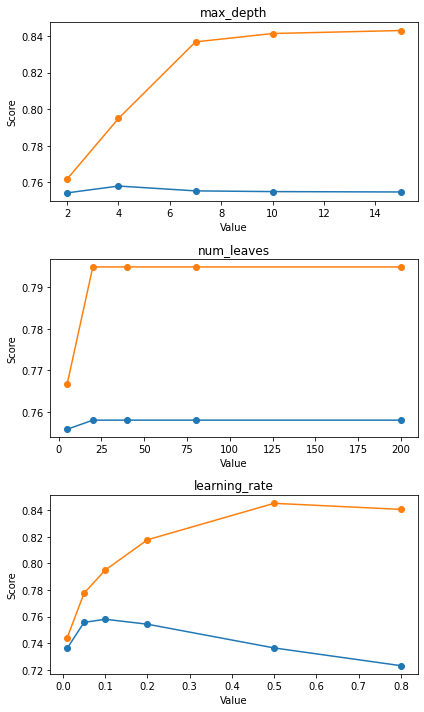

In [ ]:
# Извлекаю из кастомной кросс-валидации AUC scores и строю по ним графики

dict_len = len(valid_scores.keys())
plt.figure(figsize=(6,10))

for cycle_num, key in enumerate(valid_scores.keys()):
  a,b = extract_scores(valid_scores[key])
  a1,b1 = extract_scores(test_scores[key])

  plt.subplot(dict_len, 1, cycle_num + 1)
  plt.plot(a,b,marker='o')
  plt.plot(a1,b1,marker='o')
  plt.title(key)
  plt.ylabel('Score')
  plt.xlabel('Value')
plt.tight_layout()
plt.show()

* Оранжевые кривые - графики изменения значения score на train выборках.
* Синие кривые - графики изменения значения score на valid выборках.

Напрашивается очевидный вывод: увеличение score на обучающей train выборке далеко не значит, что score будет увеличиваться на valid выборке.

Параметр max_depth не внес очевидных изменений в результаты на valid выборке. Выяснилось, что дефолтное значение 4 - оптимальное значение для данной задачи

Уменьшение параметра num_leaves пагубно сказывается на результате. от 20 и выше динамика изменения результата не наблюдается.

С параметром learning_rate равным 0.1 достигается наилучший результат. Видимо, это оптимальный параметр скорости обучения, где алгоритм аккурат проваливается в яму и нащупывает минимум.

# 1 задание. Поиск наилучшего сочетания гиперпараметров

# GridSearchCV

In [ ]:
train_sample = train_matrix.drop(labels = 'TARGET', axis = 1, inplace = False)
target_sample = train_matrix['TARGET']

train_data = lgbm.Dataset(train_sample, label=target_sample)
lgbm_grid_model = lgbm.LGBMClassifier(boosting_type = 'gbdt',
                                      metric = 'auc',
                                      objective = 'binary',
                                      num_boost_round = 200,
                                      verbose_eval = 100
                                      )
grid_search_params = {'max_depth': [2, 4, 8],
                      'num_leaves': [2, 6, 20],
                      'learning_rate': [0.05, 0.1, 0.5],
                      'min_data_in_leaf': [10, 20, 50, 200]
                      }

GSCV = GridSearchCV(estimator = lgbm_grid_model,
                    param_grid = grid_search_params,
                    cv = 5,
                    scoring = 'roc_auc',
                    # verbose= 3 # Нужно было добавить этот параметр, чтобы выводилась инфа по проверяемым параметрам, score и номеру валидации
                    )
GCV_lgbm = GSCV.fit(train_sample, target_sample)

print(GCV_lgbm.best_params_, GCV_lgbm.best_score_)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Foun

{'learning_rate': 0.1, 'max_depth': 4, 'min_data_in_leaf': 200, 'num_leaves': 20} 0.7571323665047445


Лучшее сочетание параметров с усредненными scores на k-fold'ах по мнению GridSearchCV:
* {'learning_rate': 0.1, 'max_depth': 4, 'min_data_in_leaf': 200, 'num_leaves': 20} 
* auc_score = 0.7571323665047445

Тренировка LightGBM с подобранными параметрами на полном датасете и сабмитом на Kaggle.

Повысил количество эпох обучения до 400. Я же все таки хочу получить лучший результат.

In [ ]:
params = {'boosting_type' : 'gbdt',
          'metric' : 'auc',
          'objective' : 'binary',
          'max_depth' : 4,
          'num_leaves' : 20,
          'learning_rate' : 0.1,
          'min_data_in_leaf' : 200
          }

train_data = lgbm.Dataset(train_matrix, label=df_target)

lgbm_grid_model = lgbm.train(params,
                             train_data, 
                             valid_sets = (train_data,),
                             num_boost_round = 400,
                             verbose_eval = 50
                             )

[50]	training's auc: 0.760591
[100]	training's auc: 0.772566
[150]	training's auc: 0.780209
[200]	training's auc: 0.786311
[250]	training's auc: 0.792134
[300]	training's auc: 0.797323
[350]	training's auc: 0.802226
[400]	training's auc: 0.806766


In [ ]:
y_pred=lgbm_grid_model.predict(test_matrix)
name = 'grid_cv_400'
subm(name, y_pred)

GridSearchCV

* auc_score на train данных = 0.806766 (как у победителей соревнования ахахаха)

auc_score на Kaggle:
* Private Score = 0.74_552
* Public Score = 0.74_754

# RandomizedSearchCV

Запускал с другого аккаунта, так как основной заблочили на день

In [ ]:
lgbm_rand_model = lgbm.LGBMClassifier(boosting_type = 'gbdt',
                                      metric = 'auc',
                                      objective = 'binary',
                                      device_type = 'gpu',
                                      num_boost_round = 200,
                                      verbose_eval = 100
                                      )
rand_search_params = {'max_depth': [2, 4, 8],
                      'num_leaves': [2, 6, 20],
                      'learning_rate': [0.05, 0.1, 0.5],
                      'min_data_in_leaf': [10, 20, 50, 200]
                      }

RSCV = RandomizedSearchCV(lgbm_rand_model,
                          rand_search_params,
                          n_iter = 20,
                          cv = 5,
                          scoring = 'roc_auc',
                          verbose= 3
                          )
RCV_lgbm = RSCV.fit(train_sample, target_sample)
print(RCV_lgbm.best_params_, RCV_lgbm.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11568
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 118
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11642
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 118
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11568
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 118
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11642
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 118
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11562
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11638
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11539
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 115
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11646
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11628
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11554
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11531
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11636
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11618
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11564
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11640
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11543
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11648
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 117
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB) tra

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11554
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11531
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11636
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11618
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11554
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11630
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11531
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11636
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11618
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 111
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (17.83 MB)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:160: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11631
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 116
[LightGBM] [Info] Using GPU Device: Tesla K80, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 73 dense feature groups (22.29 MB) tra

Лучшее сочетание параметров с усредненными scores на k-fold'ах по мнению GridSearchCV:

{'num_leaves': 20, 'min_data_in_leaf': 50, 'max_depth': 4, 'learning_rate': 0.1} 

auc_score меньше, чем у сочетания параметров GridSearchCV = 0.7568225119208349

Тренировка LightGBM с подобранными параметрами на полном датасете и сабмитом на Kaggle.

Повысил количество эпох обучения. Я же все таки хочу получить лучший результат.

In [ ]:
params = {'boosting_type' : 'gbdt',
          'metric' : 'auc',
          'objective' : 'binary',
          'max_depth' : 4,
          'num_leaves' : 20,
          'learning_rate' : 0.1,
          'min_data_in_leaf' : 50
          }

train_data = lgbm.Dataset(train_matrix, label=df_target)

lgbm_rand_model = lgbm.train(params,
                             train_data, 
                             valid_sets = (train_data,),
                             num_boost_round = 400,
                             verbose_eval = 50
                             )

[50]	training's auc: 0.76105
[100]	training's auc: 0.773167
[150]	training's auc: 0.781127
[200]	training's auc: 0.788252
[250]	training's auc: 0.794679
[300]	training's auc: 0.800194
[350]	training's auc: 0.804856
[400]	training's auc: 0.80967


In [ ]:
y_pred=lgbm_rand_model.predict(test_matrix)
name = 'rand_cv_400'
subm(name, y_pred)

RandomizedSearchCV

* auc_score на train данных = 0.80967 (больше, чем на GridSearchCV)

auc_score на Kaggle RandomizedSearchCV:
* Private Score = 0.74_379
* Public Score = 0.74_878

GridSearchCV:
* Private Score = 0.74_552
* Public Score = 0.74_754

Интересное расхождение Private & Public значений. Public Score увеличился по сравнению с моделью по параметрам GridSearch, однако Private уменьшился на несколько тысячных. С такой моделью я бы точно не пошел получать призовые.

GridSearch показывает стабильно НОРМАЛЬНЫЕ результаты. 

# 2 задание. Графики Feature Importance

Строим Feature Importance по лучшему результату GridSearchCV

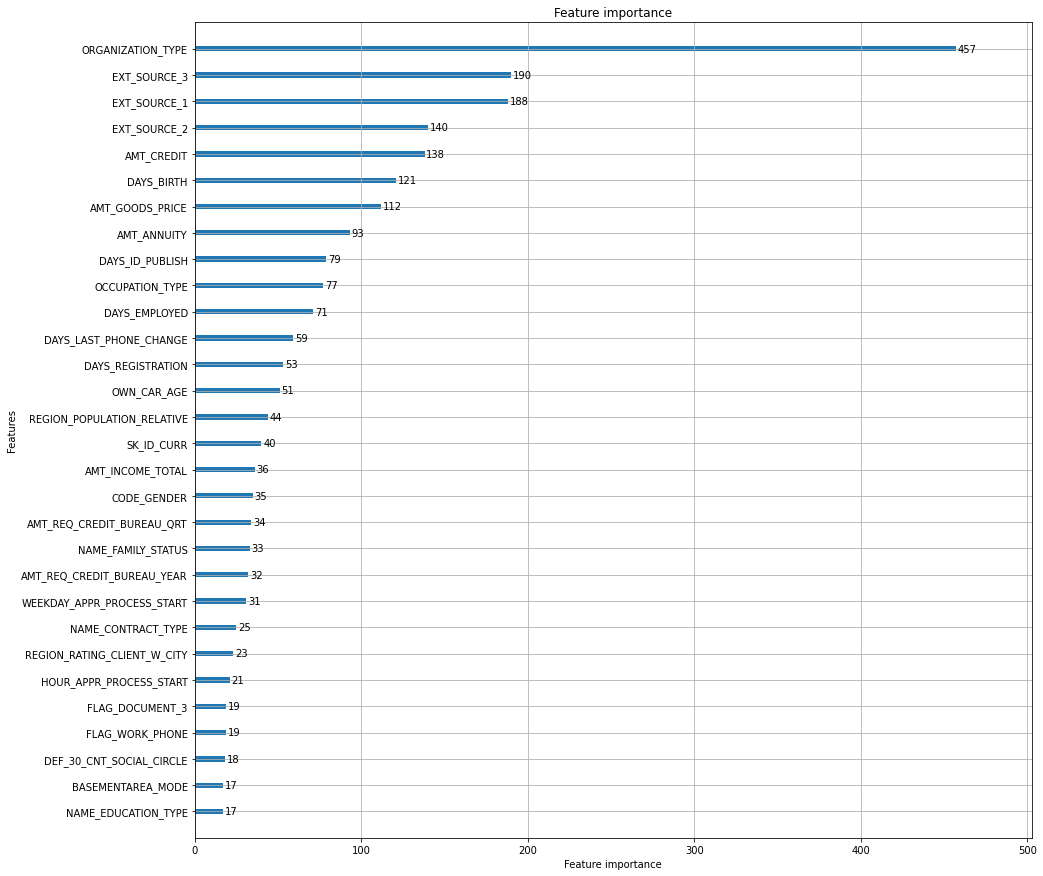

In [ ]:
lgbm.plot_importance(GCV_lgbm.best_estimator_, max_num_features = 30, figsize = (15,15))

Строим Feature Importance по лучшему результату RandomizedSearchCV

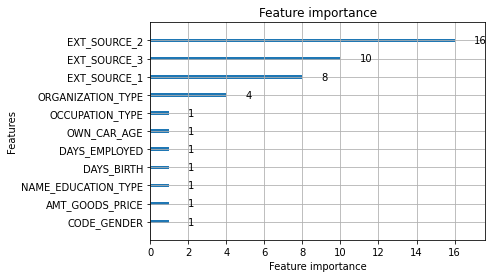

In [ ]:
lgbm.plot_importance(RCV_lgbm.best_estimator_, max_num_features = 30)

Что интересно, самыми важными оказались признаки, у которых значения в матрице корреляции были наибольшими.

# Стекинг

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split

cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
  'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 
  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
  'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 
  'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 
  'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

Stack_cols = [col for col in train_matrix.columns if col not in cat_features]

# lightgbm.LGBMRegressor

estimators = [('ridge', RidgeCV()), 
              ('lasso', LassoCV(random_state=42)),
              ('knr', KNeighborsRegressor(n_neighbors=20,
                                          metric='euclidean'))]
final_estimator = GradientBoostingRegressor(
     n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1,
     random_state=42)

reg = StackingRegressor(
     estimators = estimators,
     final_estimator = final_estimator)

train_matrix
test_matrix
df_target


X_train, X_test, y_train, y_test = train_test_split(train_matrix, df_target,
                                                    random_state=42)
reg.fit(X_train, y_train)






In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split

import lightgbm as lgbm

# на случай обучения исключительно на количественных признаках
# train_matrix_no_cat = train_matrix.drop(labels = cat_features, axis = 1)
# df_target

# Прописываю параметры оценщиков и собираю в 1 список
estimators = [('lgbm_gbdt_surf_1',lgbm.LGBMRegressor(boosting_type = 'gbdt',
                                                     max_depth = 3,
                                                     min_data_in_leaf = 300,
                                                     n_estimators = 400)),
              ('lgbm_gbdt_deep_2',lgbm.LGBMRegressor(boosting_type = 'gbdt',
                                                     max_depth = 8,
                                                     min_data_in_leaf = 10,
                                                     n_estimators = 400)),
              ('lgbm_dart_surf_3',lgbm.LGBMRegressor(boosting_type = 'dart',
                                                     max_depth = 3,
                                                     min_data_in_leaf = 300,
                                                     n_estimators = 400)),
              ('lgbm_dart_deep_4',lgbm.LGBMRegressor(boosting_type = 'dart',
                                                     max_depth = 8,
                                                     min_data_in_leaf = 10,
                                                     n_estimators = 400))
              ]

# задаю параметры финального оценщика
final_estimator = GradientBoostingRegressor(
     n_estimators=25, min_samples_leaf=25)

# задаю параметры Стекинга
reg = StackingRegressor(
     estimators = estimators,
     final_estimator = final_estimator, verbose = 5)

# Разделяю набор данных на train test
X_train, X_test, y_train, y_test = train_test_split(train_matrix,df_target,train_size = 0.8, shuffle=True)

# Запускаю обучение Стека
reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   59.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

StackingRegressor(estimators=[('lgbm_gbdt_surf_1',
                               LGBMRegressor(max_depth=3, min_data_in_leaf=300,
                                             n_estimators=400)),
                              ('lgbm_gbdt_deep_2',
                               LGBMRegressor(max_depth=8, min_data_in_leaf=10,
                                             n_estimators=400)),
                              ('lgbm_dart_surf_3',
                               LGBMRegressor(boosting_type='dart', max_depth=3,
                                             min_data_in_leaf=300,
                                             n_estimators=400)),
                              ('lgbm_dart_deep_4',
                               LGBMRegressor(boosting_type='dart', max_depth=8,
                                             min_data_in_leaf=10,
                                             n_estimators=400))],
                  final_estimator=GradientBoostingRegressor(min_samples_leaf=25,
  

In [33]:
y_pred = reg.predict(X_test)
print(round(roc_auc_score(y_test, y_pred),5))

0.75884


In [35]:
y_pred = reg.predict(test_matrix)

In [36]:
subm('stack_lgbm', y_pred)

Вопрос
* Можно ли с помощью StackingRegressor из SKLEARN объединять ПРЕДОБУЧЕННЫЕ модели?

Результаты стекинга 4 разных LightGMB моделей на Kaggle:
* Private Score = 0.74183
* Public Score = 0.74145 

Объединил разные типы моделей с глубоким и поверхностным спусками вглубь дерева. Результаты не оправдали ожидания. Вполне возможно, что это связано с использованием моделей, которые в основе обучения используют один и тот же принцип

Модели из sklearn, которые можно использовать для стекинга.
Проблема в том, что некоторые из них не воспринимают категориальные фичи в формате object. Поэтому для использования моделей данные нужно предобработать 
(перевести кат фичи в цифру, избавиться от NaN's, Привести к 1 масштабу)
* DecisionTreeRegressor
* LassoCV
* RandomForestRegressor
* LinearSVC
* KNeighborsRegressor